In [255]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [256]:
im =cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float32) / 255.0 

In [257]:
s = 12
h, w = gray.shape

scale_space = np.empty((h, w, s), dtype=np.float32)
radius = np.arange(1, 13, 1)
sigmas = radius / np.sqrt(2)
print(sigmas)
#Gaussian kernal
for i, sigma in enumerate(sigmas):
    log_hw = int(3 * sigma)
    X, Y = np.meshgrid(np.arange(-log_hw, log_hw + 1, 1), np.arange(-log_hw, log_hw + 1, 1))
    log = 1/(2*np.pi*sigma**2)*(X**2/(sigma**2) + Y**2/(sigma**2) - 2)*np.exp(-(X**2 + Y**2)/(2*sigma**2))
    f_log = cv.filter2D(gray, -1, log)
    scale_space[:, :, i] = f_log

[0.70710678 1.41421356 2.12132034 2.82842712 3.53553391 4.24264069
 4.94974747 5.65685425 6.36396103 7.07106781 7.77817459 8.48528137]


In [258]:
#Scale space extrema detection
extrema = np.zeros_like(scale_space, dtype=bool)

for k in range(1, s-1):
    for i in range(1, h-1):
        for j in range(1, w-1):
            # Extract 3x3x3 neighborhood
            neighborhood = scale_space[i-1:i+2, j-1:j+2, k-1:k+2]
            center_value = scale_space[i, j, k]
            
            # Check if center is the maximum in the neighborhood
            if center_value >= np.max(neighborhood):
                extrema[i, j, k] = True

In [259]:
# Optional threshold to remove noise responses
threshold = 0.295
extrema = extrema & (scale_space > threshold)

# Get coordinates of blob centers
y, x, s_idx = np.where(extrema)
radii = np.sqrt(2) * sigmas[s_idx]

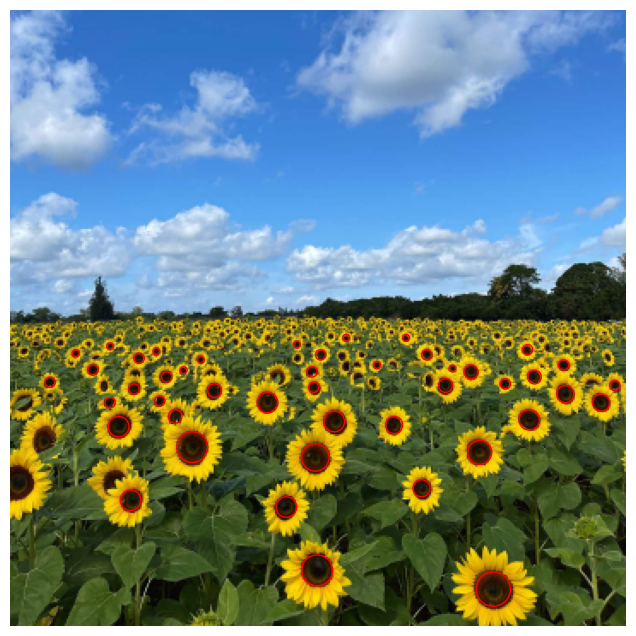

In [260]:
out = im.copy()
for (x0, y0, r) in zip(x, y, radii):
    if r > 1:  # ignore too small
        cv.circle(out, (x0, y0), int(r), (0, 0, 255), 1)

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
for (x0, y0, r) in zip(x, y, radii):
    if r > 1:
        circ = Circle((x0, y0), r, color='r', fill=False, linewidth=1)
        ax.add_patch(circ)
ax.axis('off')
plt.show()

In [276]:
#Question 3
background = cv.imread('castlecornerwall3dsmodel001.jpg')  
flag   = cv.imread('england.jpg') 

In [277]:
h, w = flag.shape[:2]
src_pts = np.array([[0,0], [w,0], [w,h], [0,h]], dtype=np.float32)
h_t, w_t = background.shape[:2]
dst_pts = np.array([
    [1185, 538],   # top-left on target
    [1669, 301],   # top-right
    [1635, 507],   # bottom-right
    [1192, 784]    # bottom-left
], dtype=np.float32)

In [278]:
#Compute homography
H, status = cv.findHomography(src_pts, dst_pts)

#Wrap the flag with background image
warped_flag = cv.warpPerspective(flag, H, (w_t, h_t))

#Create mask for blending
gray = cv.cvtColor(warped_flag, cv.COLOR_BGR2GRAY)
_, mask = cv.threshold(gray, 1, 255, cv.THRESH_BINARY)

#Simple alpha blend (hard paste)
alpha = 0.5  
mask_bool = mask.astype(bool)
result = background.copy()
result[mask_bool] = cv.addWeighted(warped_flag, alpha, background, 1-alpha, 0)[mask_bool]

# Save
cv.imwrite("castle_flag.jpg", result)

True

In [67]:
#Question 2
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib

In [68]:
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3 # Center
s = r / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line)) # All points

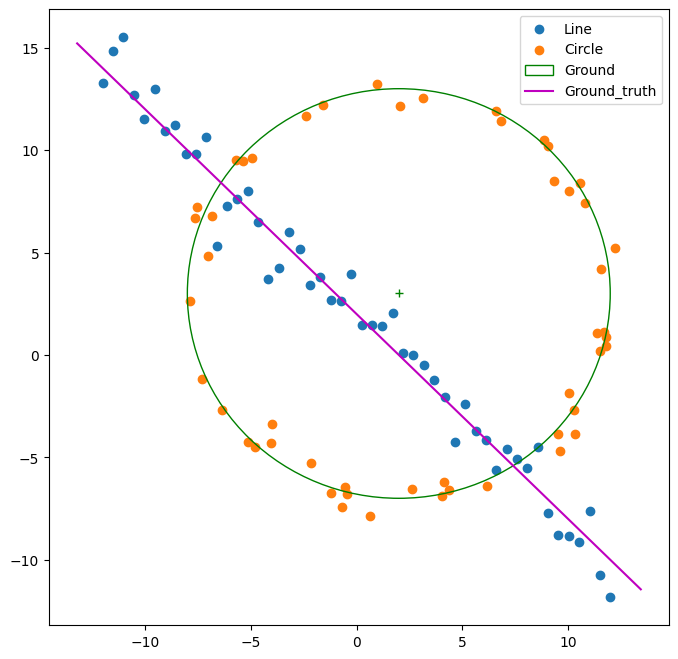

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth')

plt.legend()
plt.show()

In [70]:
#Tke the inliers of the predicted shape
def get_inliers_line(X, a, b, d, threshold):
    distances = np.abs(a*X[:,0] + b*X[:,1] - d)
    inliers = np.where(distances < threshold)[0]
    return inliers

def ransac_line(X, num_iter=1000, threshold=0.5):
    best_inliers = []
    best_params = None    
    for i in range(num_iter):
        sample_idx = np.random.choice(X.shape[0], 2, replace=False)
        p1, p2 = X[sample_idx]
        line_vec = p2 - p1
        normal = np.array([-line_vec[1], line_vec[0]])
        normal = normal / np.linalg.norm(normal)  # enforce ||[a,b]||=1
        d = np.dot(normal, p1)
        inliers = get_inliers_line(X, normal[0], normal[1], d, threshold)
        
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_params = (normal[0], normal[1], d)
    return best_params, best_inliers

In [71]:
line_params, line_inliers = ransac_line(X, num_iter=1000, threshold=0.5)
print("Line parameters (a,b,d):", line_params)
print("Number of inliers:", len(line_inliers))

Line parameters (a,b,d): (0.7261831225073551, 0.6875013255154261, 1.3752209297017952)
Number of inliers: 28


In [72]:
def get_inliers_circle(X, center, radius, threshold):
    distances = np.sqrt((X[:,0] - center[0])**2 + (X[:,1] - center[1])**2)
    errors = np.abs(distances - radius)
    inliers = np.where(errors < threshold)[0]
    return inliers

def fit_circle_least_squares(X_sample):
    x0_init = np.mean(X_sample[:,0])
    y0_init = np.mean(X_sample[:,1])
    r_init = np.mean(np.sqrt((X_sample[:,0]-x0_init)**2 + (X_sample[:,1]-y0_init)**2))
    
    def cost(params):
        x0, y0, r = params
        return np.sum((np.sqrt((X_sample[:,0]-x0)**2 + (X_sample[:,1]-y0)**2) - r)**2) 
        
    res = minimize(cost, [x0_init, y0_init, r_init])
    return res.x  # x0, y0, r

def ransac_circle(X, num_iter=1000, threshold=0.5, min_inliers=30):
    best_inliers = []
    best_params = None  
    for i in range(num_iter):
        sample_idx = np.random.choice(X.shape[0], 3, replace=False)
        X_sample = X[sample_idx]
        x0, y0, r = fit_circle_least_squares(X_sample)
        inliers = get_inliers_circle(X, (x0, y0), r, threshold)
   
        if len(inliers) > len(best_inliers) and len(inliers) >= min_inliers:
            best_inliers = inliers
            best_params = (x0, y0, r)
    
    return best_params, best_inliers

In [73]:
X_remnant = np.delete(X, line_inliers, axis=0)

circle_params, circle_inliers = ransac_circle(X_remnant, num_iter=1000, threshold=0.5, min_inliers=30)
print("Circle parameters (x0, y0, r):", circle_params)
print("Number of circle inliers:", len(circle_inliers))

Circle parameters (x0, y0, r): (2.221026452449121, 2.982251593115918, 9.821219196885902)
Number of circle inliers: 41


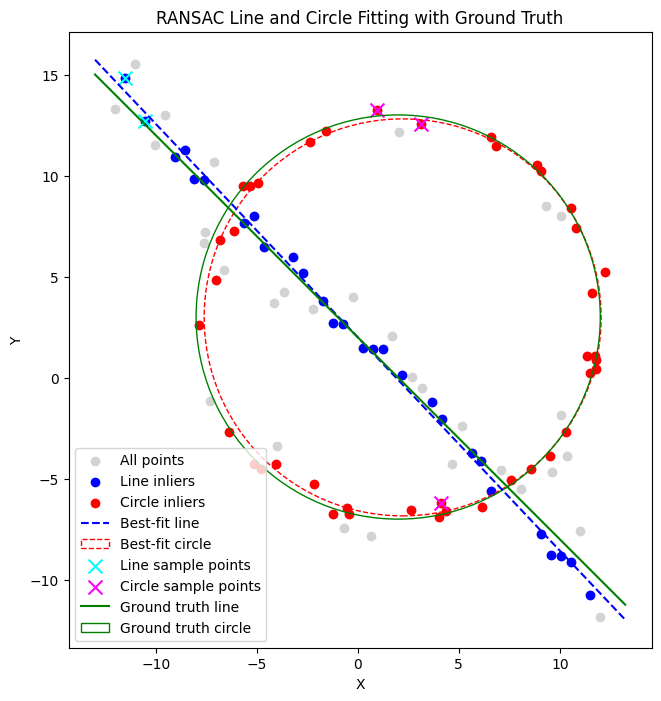

In [74]:
x0_gt, y0_gt = 2, 3  # Circle center
r_gt = 10             # Circle radius
m_gt, b_gt = -1, 2    # Line: y = m*x + b

# Plot setup
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:,0], X[:,1], color='lightgray', label='All points')
ax.scatter(X[line_inliers,0], X[line_inliers,1], color='blue', label='Line inliers')

circle_inlier_points = X_remnant[circle_inliers]
ax.scatter(circle_inlier_points[:,0], circle_inlier_points[:,1], color='red', label='Circle inliers')

#Estimated Line
a, b, d = line_params
x_vals = np.linspace(np.min(X[:,0])-1, np.max(X[:,0])+1, 200)
y_vals = (d - a*x_vals)/b
ax.plot(x_vals, y_vals, color='blue', linestyle='--', label='Best-fit line')

#Estimated Circle
x0, y0, r = circle_params
circle_patch = plt.Circle((x0, y0), r, color='red', fill=False, linestyle='--', label='Best-fit circle')
ax.add_patch(circle_patch)

ax.scatter(X[line_inliers[:2],0], X[line_inliers[:2],1], color='cyan', s=100, marker='x', label='Line sample points')
ax.scatter(circle_inlier_points[:3,0], circle_inlier_points[:3,1], color='magenta', s=100, marker='x', label='Circle sample points')

x_gt = np.array([np.min(X[:,0])-1, np.max(X[:,0])+1])
y_gt = m_gt*x_gt + b_gt
ax.plot(x_gt, y_gt, color='green', linestyle='-', label='Ground truth line')

# Plot ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r_gt, color='green', fill=False, linestyle='-', label='Ground truth circle')
ax.add_patch(circle_gt)

# Labels, legend, equal aspect
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('RANSAC Line and Circle Fitting with Ground Truth')
ax.legend()
ax.set_aspect('equal')
plt.show()


In [261]:
#Question 4
def extract_sift_features(img):
    sift = cv.SIFT_create(nfeatures=7000)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return keypoints, descriptors

In [262]:
def match_sift_bruteforce(des1, des2):
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)  # Sort by distance (best first)
    return matches

In [263]:
def draw_matches(img1, kp1, img2, kp2, matches, max_matches=500):
    matched_image = cv.drawMatches(
        img1, kp1,
        img2, kp2,
        matches[:max_matches], None,
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.figure(figsize=(10, 10))
    plt.imshow(matched_image)
    plt.title("SIFT Feature Matches")
    plt.axis('off')
    plt.show()

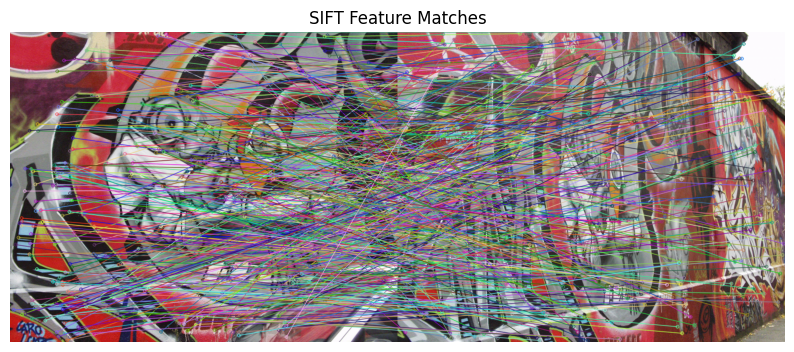

In [265]:
# Load and preprocess images
img1 = cv.imread('img1.ppm')
img1 = cv.cvtColor(img1, cv.IMREAD_ANYCOLOR)
img2 = cv.imread('img5.ppm')
img2 = cv.cvtColor(img2, cv.IMREAD_ANYCOLOR)

# Extract and match features
kp1, des1 = extract_sift_features(img1)
kp2, des2 = extract_sift_features(img2)
good_matches = match_sift_bruteforce(des1, des2)

# Draw the good matches
draw_matches(img1, kp1, img2, kp2, good_matches)


In [266]:
#Find homography parameters
def compute_homography(src_pts, dst_pts):
    A = []
    for (x1, y1), (x2, y2) in zip(src_pts, dst_pts):
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])
    A = np.asarray(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    return H / H[2, 2]

def apply_homography(H, pts):
    pts_h = np.hstack([pts, np.ones((pts.shape[0], 1))])
    pts_t = (H @ pts_h.T).T
    pts_t = pts_t[:, :2] / pts_t[:, 2, None]
    return pts_t

def find_best_homography_RANSAC(kp1, kp2, matches, thresh=5.0, max_iter=2000):
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches])
    best_inliers = []
    best_H = None

    for _ in range(max_iter):
        idx = np.random.choice(len(matches), 4, replace=False)
        H = compute_homography(src_pts[idx], dst_pts[idx])

        projected = apply_homography(H, src_pts)
        error = np.linalg.norm(projected - dst_pts, axis=1)
        inliers = np.where(error < thresh)[0]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H

    return best_H

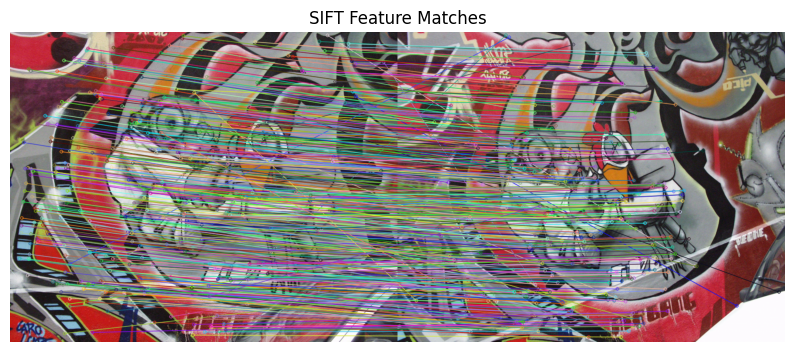

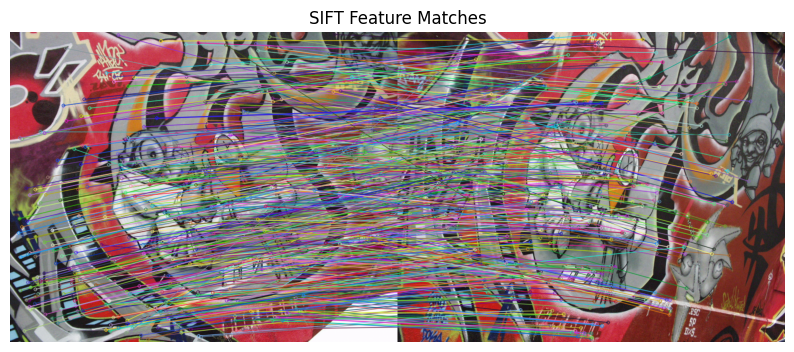

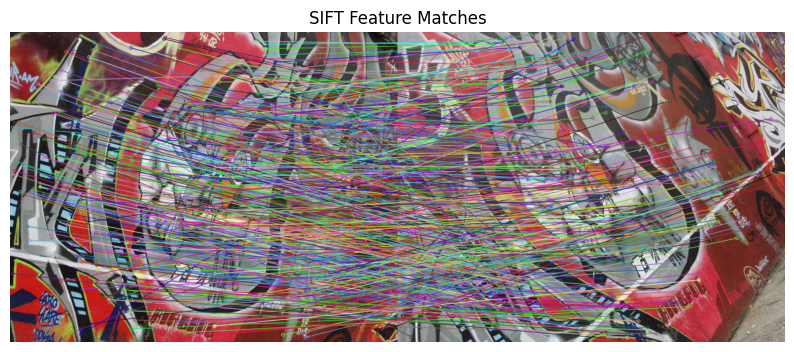

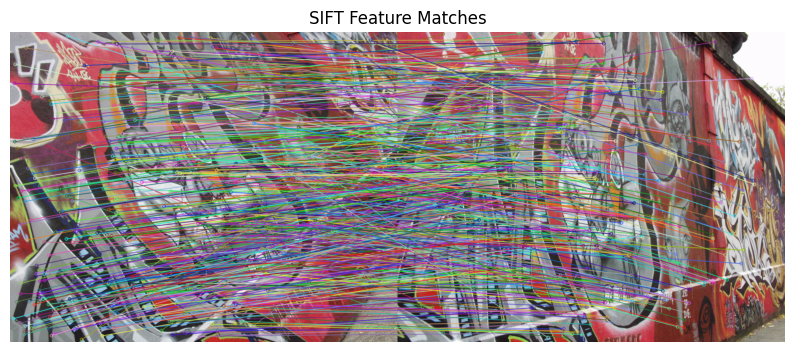

Homography matrix for img1 to img2:
[[ 8.91687293e-01  3.17974011e-01 -4.17828172e+01]
 [-1.78055395e-01  9.47398827e-01  1.51389916e+02]
 [ 2.14862090e-04 -1.27669571e-05  1.00000000e+00]]

Homography matrix for img2 to img3:
[[ 6.79196950e-01 -5.36548564e-01  3.31429556e+02]
 [ 6.05159895e-01  8.66954065e-01 -1.87061578e+02]
 [ 1.70965336e-04 -5.22743747e-05  1.00000000e+00]]

Homography matrix for img3 to img4:
[[ 5.70832464e-01  8.48681196e-01 -9.52402937e+01]
 [-6.96688784e-01  7.80813156e-01  3.67248106e+02]
 [ 1.26721595e-04  1.68990690e-05  1.00000000e+00]]

Homography matrix for img4 to img5:
[[ 6.42034301e-01 -3.92086488e-01  2.97973903e+02]
 [ 5.68225419e-01  7.62169157e-01 -1.17583206e+02]
 [ 6.30036162e-05 -8.93373856e-05  1.00000000e+00]]



In [271]:
image_paths = [
    'img1.ppm',
    'img2.ppm',
    'img3.ppm',
    'img4.ppm',
    'img5.ppm'
]

# Load the images
images = []
for path in image_paths:
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.IMREAD_ANYCOLOR)
    images.append(img)

# Compute homographies and plot SIFT feature matching for each pair of images
homographies = []
for i in range(len(images) - 1):
    kp_1img, des_1img = extract_sift_features(images[i])
    kp_2img, des_2img = extract_sift_features(images[i+1])
    good_matches_img = match_sift_bruteforce(des_1img, des_2img)
    src_points = np.float32([kp_1img[m.queryIdx].pt for m in good_matches_img])
    dst_points = np.float32([kp_2img[m.trainIdx].pt for m in good_matches_img])
    homography = find_best_homography_RANSAC(kp_1img, kp_2img, good_matches_img)
    homographies.append(homography)
    draw_matches(images[i], kp_1img, images[i+1], kp_2img, good_matches_img)

# Print the computed homographies
for i, H in enumerate(homographies):
    print(f"Homography matrix for img{i+1} to img{i+2}:")
    print(H)
    print()

In [272]:
# ---- Part (b): Compute homography using your RANSAC ----
final_homography = np.eye(3)
for i, H in enumerate(homographies):
    final_homography = final_homography @ H

print("Homography estimated using your RANSAC:\n", final_homography)
print("Number of inliers:", len(inliers))

# ---- Compare with dataset homography ----
H_dataset = np.loadtxt('H1to5p')  # assuming dataset homography is stored as plain text
print("\nHomography from dataset:\n", H_dataset)

Homography estimated using your RANSAC:
 [[ 6.92526398e-01  1.49220251e-01  1.67885979e+02]
 [ 4.07737794e-01  9.76508489e-01 -3.81400749e+01]
 [ 4.22362284e-04 -1.51245869e-04  1.09217683e+00]]
Number of inliers: 1063

Homography from dataset:
 [[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


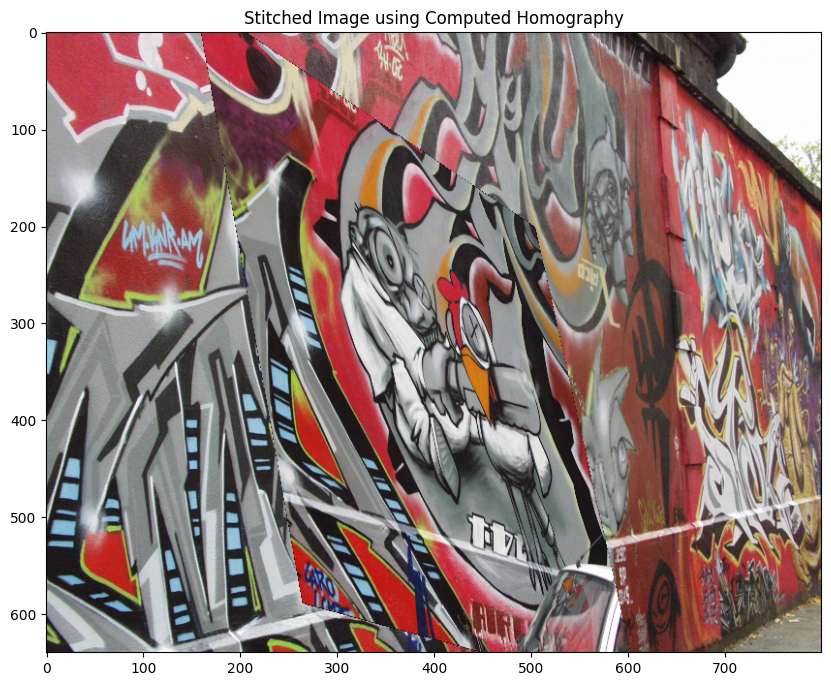

In [273]:
img1_warped = cv.warpPerspective(img1, final_homography, (img2.shape[1], img2.shape[0]))
_, img1_mask = cv.threshold(cv.cvtColor(img1_warped, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
img2_mask = cv.bitwise_not(img1_mask)

# Blend the two images together
result = cv.bitwise_and(img2, img2, mask=img2_mask)
result = cv.add(result, img1_warped)

# Display the stitched image
plt.figure(figsize=(10, 10))
plt.title('Stitched Image using Computed Homography')
plt.imshow(result)
plt.show()

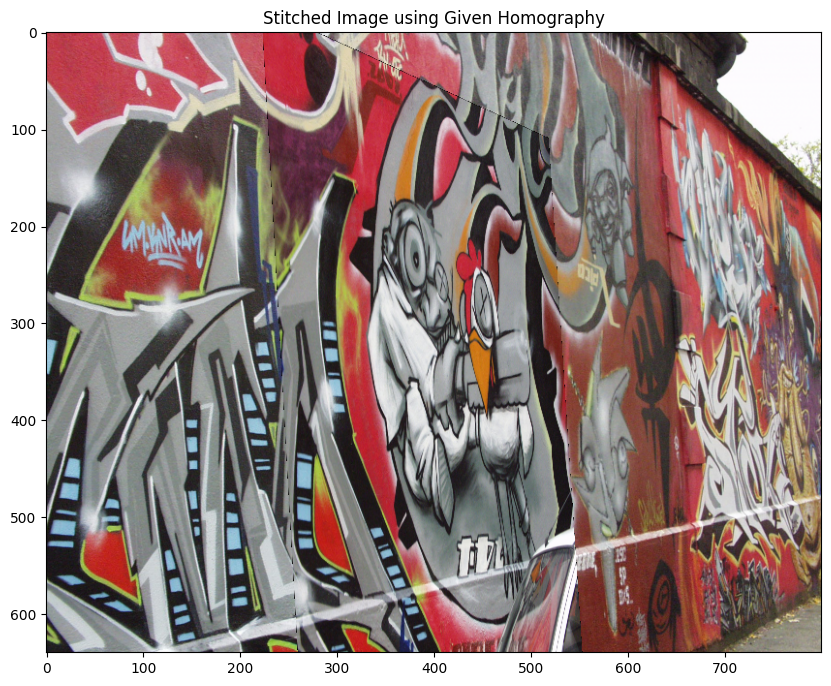

In [275]:
H_dataset = np.loadtxt('H1to5p')

img1_warped = cv.warpPerspective(img1, H_dataset, (img2.shape[1], img2.shape[0]))
_, img1_mask = cv.threshold(cv.cvtColor(img1_warped, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
img2_mask = cv.bitwise_not(img1_mask)

# Blend the two images together
result = cv.bitwise_and(img2, img2, mask=img2_mask)
result = cv.add(result, img1_warped)

# Display the stitched image
plt.figure(figsize=(10, 10))
plt.title('Stitched Image using Given Homography')
plt.imshow(result)
plt.show()